In [8]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd 
import sys
import pickle
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.metrics import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import math

workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)

import allensdk.core.json_utilities as ju
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

from mcmodels.core import VoxelModelCache
from mcmodels.core.utils import get_structure_id,get_ordered_summary_structures
from mcmodels.core.connectivity_data import get_connectivity_data
#from mcmodels.models.crossvalidation import get_nwloocv_predictions_multimodel_merge_dists
from mcmodels.utils import nonzero_unique #, unionize
from mcmodels.models.crossvalidation import get_best_hyperparameters,get_loss_best_hyp,get_loss#get_loocv_predictions,get_loss#get_best_hyperparameters,get_loss_best_hyp,get_loocv_predictions,get_loss
from mcmodels.core.utils import get_leaves_ontologicalorder, get_indices, get_indices2,get_eval_indices,screen_index_matrices,screen_index_matrices2,screen_index_matrices3#get_cre_status,get_minorstructure_dictionary,get_leaves_ontologicalorder
from mcmodels.core.utils import get_indices_2ormore

# from mcmodels.core.utils import get_regionalized_normalized_data
# from mcmodels.core.utils import get_connectivity
# from mcmodels.core.utils import get_ontological_order_leaf
# from mcmodels.core.utils import get_nw_loocv,get_wt_inds
# from mcmodels.core.utils import get_countvec
# from mcmodels.core.utils import get_injection_hemisphere_id
# from mcmodels.core.utils import get_structure_id, get_ordered_summary_structures,get_minorstructures,get_loss_paper
# from mcmodels.core.experiment import get_voxeldata_msvd
from mcmodels.regressors import NadarayaWatson
from mcmodels.core.plotting import plot_loss_surface,plot_loss_scatter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#read data
TOP_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
INPUT_JSON = os.path.join(TOP_DIR, 'input_011520.json')
EXPERIMENTS_EXCLUDE_JSON = os.path.join(TOP_DIR, 'experiments_exclude.json')
FILE_DIR = '/Users/samsonkoelle/alleninstitute/mcm_2020/mcm_updated/'
OUTPUT_DIR = os.path.join(FILE_DIR, 'output')

input_data = ju.read(INPUT_JSON)
manifest_file = input_data.get('manifest_file')
manifest_file = os.path.join(TOP_DIR, manifest_file)
experiments_exclude = ju.read(EXPERIMENTS_EXCLUDE_JSON)

#its unclear why the hyperparameters are loaded from the output directory
cache = VoxelModelCache(manifest_file=manifest_file)
major_structures = input_data.get('structures')
major_structure_ids = [get_structure_id(cache, s) for s in major_structures]
data_info = pd.read_excel('/Users/samsonkoelle/alleninstitute/Whole Brain Cre Image Series_curation only.xlsx', 'all datasets curated_070919pull')
data_info.set_index("id", inplace=True)
ontological_order = get_ordered_summary_structures(cache)

mcc = MouseConnectivityCache(manifest_file = '../connectivity/mouse_connectivity_manifest.json')
st = mcc.get_structure_tree()
ai_map = st.get_id_acronym_map()
ia_map = {value: key for key, value in ai_map.items()}

#regionalize voxel model: compare with regional model
#regional parameters
cre = None
eid_set=None
high_res=False
threshold_injection = False

COARSE_STRUCTURE_SET_ID = 2
DEFAULT_STRUCTURE_SET_IDS = tuple([COARSE_STRUCTURE_SET_ID])
tree = cache.get_structure_tree()
default_structures = tree.get_structures_by_set_id(DEFAULT_STRUCTURE_SET_IDS)
default_structure_ids = [st['id'] for st in default_structures if st['id'] != 934]
#cre= True

annotation/ccf_2017


In [3]:
connectivity_data = get_connectivity_data(cache, major_structure_ids, experiments_exclude, remove_injection = False)

512
703
1089
1097
315
313
354
698
771
803
477
549


In [4]:
connectivity_data.get_injection_hemisphere_ids()
connectivity_data.align()
connectivity_data.get_centroids()
connectivity_data.get_data_matrices(default_structure_ids)
connectivity_data.get_crelines(data_info)

In [9]:
#major division segregation is legacy code but convenient for fast cross validation in major division model
#experiments_minor_structures = get_summarystructure_dictionary(connectivity_data, data_info)
#get leaves in ontological order.  Where leafs don't exist, uses summary structure
ontological_order_leaves = get_leaves_ontologicalorder(connectivity_data, ontological_order)
#Key isn't affected by which experiment we choose. This allows default masking to be inherited from the AllenSDK.
sid0 = list(connectivity_data.structure_datas.keys())[0]
eid0 = list(connectivity_data.structure_datas[sid0].experiment_datas.keys())[0]
#Identify keys denoting which voxels correspond to which structure in the ipsi and contra targets.
#contra_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=1)
#ipsi_targetkey = msvd.experiments[list(msvd.experiments.keys())[0]].projection_mask.get_key(structure_ids=ontological_order_leaves, hemisphere_id=2)
contra_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=1)
ipsi_targetkey = connectivity_data.structure_datas[sid0].projection_mask.get_key(structure_ids=ontological_order, hemisphere_id=2)
#get average intensities of projection structures given ipsi and contra keys
#source_key = ontological_order #only relevant here when injection needs to be unionized, but currently a required argument
ipsi_target_regions, ipsi_target_counts = nonzero_unique(ipsi_targetkey, return_counts=True)
contra_target_regions, contra_target_counts = nonzero_unique(contra_targetkey, return_counts=True)

target_order = lambda x: np.array(ontological_order)[np.isin(ontological_order, x)]
permutation = lambda x: np.argsort(np.argsort(target_order(x)))
targ_ids = np.concatenate([ipsi_target_regions[permutation(ipsi_target_regions)],
                           contra_target_regions[permutation(contra_target_regions)]])

In [10]:
with open('data/info/leafs.pickle', 'rb') as handle:
    leafs = pickle.load(handle)
    
connectivity_data.ai_map = ai_map
connectivity_data.get_summarystructures(data_info)
connectivity_data.leafs = leafs
connectivity_data.get_regionalized_normalized_data(ontological_order, ipsi_targetkey, contra_targetkey)
connectivity_data.get_creleaf_combos()
connectivity_data.leaf2_index_matrices = get_indices_2ormore(connectivity_data.leafs)
connectivity_data.creleaf2_index_matrices = get_indices_2ormore(connectivity_data.creleaf_combos)

In [11]:

def get_cre_distances(projections, means_cast, sids, cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = means_cast[sids[i]][cres[i]]#means_cast.loc[tuple([cres[i], sids[i]])]
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[i,j]  = np.linalg.norm(meani - meanj)#**2
    return(credist)
def get_loss_surface_cv(projections, centroids, cres, sids,fraction, gamma = 100000):
    means_cast = get_means(projections, cres, sids)
    cre_distances_cv = get_cre_distances_cv(projections, means_cast, sids, cres)
    surface = get_surface_from_distances(projections,centroids,cre_distances_cv, fraction, gamma)
    surface.cre_distances_cv = cre_distances_cv
    return(surface)

def get_surface_from_distances(projections,centroids,cre_distances, fraction, gamma = 100000):
    
    nsamp = centroids.shape[0]
    pairs = np.asarray(np.where(~np.isnan(cre_distances))).transpose() #not all cres will have distances, e.g. if not in same leaf
    ngp = pairs.shape[0]
    
    coordinates = np.zeros((ngp,2))
    projection_distances = np.zeros((ngp,1))
    for i in range(ngp):
        coordinates[i,0] = np.linalg.norm(centroids[pairs[i][0]] - centroids[pairs[i][1]])**2
        coordinates[i,1] = cre_distances[pairs[i][0]][pairs[i][1]]
        projection_distances[i] = np.linalg.norm(projections[pairs[i][0]] - projections[pairs[i][1]])**2
    coordinates_normed = coordinates / np.linalg.norm(coordinates, axis = 0)#**2

    surface = NadarayaWatson(kernel='rbf',  gamma  = gamma)
    randos = random.sample(list(range(ngp)), math.floor(ngp * fraction))
    surface.fit(coordinates_normed[randos], projection_distances[randos])
    surface.coordinates_normed = coordinates_normed
    surface.norms = np.linalg.norm(coordinates, axis = 0)
    surface.projection_distances = projection_distances
    return(surface)

# def get_cre_distances_cv(proj, means_cast, sids,cres):
#     nsamp = cres.shape[0]
#     credist = np.empty((nsamp,nsamp))
#     credist[:] = np.nan
#     for i in range(nsamp):
#         print(i)
#         meani = meani = means_cast[sids[i]][cres[i]]
#         ls = np.where(leafs[sid] == leafs[sid][i])[0]
#         crs = np.where(cres == cres[i])[0]
#         ncr = len(np.intersect1d(ls, crs))
        
#         meanloocvi = meani
#         if ncr > 1:
#             meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
#         else:
#             meanloocvi = np.zeros(proj[i].shape[0])
#             meanloocvi[:] = np.nan
            
#         for j in range(nsamp):
#             meanj = means_cast[sids[j]][cres[j]]
#             if sids[j] == sids[i]:
#                 credist[i,j]  = np.linalg.norm(meanloocvi - meanj)

#     return(credist)

def get_means(projections, cres, sids):
    cre_means = {}
    cre_types = np.unique(cres)
    sid_types = np.unique(sids)
    for i in range(len(sid_types)):
        cre_means[sid_types[i]] = {}
        sid_inds = np.where(sids == sid_types[i])[0]
        for j in range(len(cre_types)): 
            cre_inds = np.where(cres == cre_types[j])[0]
            cre_means[sid_types[i]][cre_types[j]] = np.mean(projections[np.intersect1d(sid_inds, cre_inds)], axis = 0 )
    return(cre_means)

def get_cre_distances_cv(proj, means_cast, sids,cres):
    nsamp = cres.shape[0]
    credist = np.empty((nsamp,nsamp))
    credist[:] = np.nan
    for i in range(nsamp):
        #print(i)
        meani = meani = means_cast[sids[i]][cres[i]]
        ls = np.where(leafs[sid] == leafs[sid][i])[0]
        crs = np.where(cres == cres[i])[0]
        ncr = len(np.intersect1d(ls, crs))
        
        meanloocvi = meani
        if ncr > 1:
            meanloocvi = (ncr * meani ) / (ncr - 1) -   (1/ ncr)* proj[i] #results[reg[i]][tuple([cs[reg_cre_ind[j],1], cs[reg_cre_ind[k],1]])]
        else:
            meanloocvi = np.zeros(proj[i].shape[0])
            meanloocvi[:] = np.nan
            
        for j in range(nsamp):
            meanj = means_cast[sids[j]][cres[j]]
            if sids[j] == sids[i]:
                credist[j,i]  = np.linalg.norm(meanloocvi - meanj)

    return(credist)

def get_embedding_cv(surface, dists, cre_distances_cv):
    
    ntrain = dists.shape[0]
    norms = surface.norms
    leaf_pairs = np.asarray(np.where(~np.isnan(cre_distances_cv))).transpose()
    nlp = leaf_pairs.shape[0]
    
    losses = np.zeros((ntrain, ntrain))
    for i in range(nlp):
        d_ij = dists[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[0]
        p_ij = cre_distances_cv[leaf_pairs[i][0]][leaf_pairs[i][1]] / norms[1]
        losses[leaf_pairs[i][0]][leaf_pairs[i][1]] = surface.predict(np.asarray([[d_ij, p_ij]]))
      
    losses[np.where(losses == 0)] = np.nan
    
    return(losses)


from mcmodels.core import Mask


def get_embedding(surface, dists, cres = None, cre = None, means = None):
    
    ntrain = dists.shape[0]
    neval = dists.shape[1]
    norms = surface.norms
    #cnorm = surface.cnorm
    
    cre_deezy = np.zeros((ntrain))
    
    for i in range(ntrain):
        cre_deezy[i] = np.linalg.norm(means[cres[i]] - means[cre])
    
    losses = np.zeros((ntrain, neval))
    for i in range(ntrain):
        for j in range(neval):
            d_ij = dists[i,j] / norms[0]
            p_i = cre_deezy[i] / norms[1]
            losses[i,j] = surface.predict(np.asarray([[d_ij, p_i]]))
            
    return(losses)



def get_nw_predictions(projections, dists, gamma):
  
     
    projections = np.asarray(projections, dtype=np.float32)
    neval = dists.shape[1]
    #nexp = centroids.shape[0]
    predictions = np.zeros((neval, projections.shape[1]))
    predictions[:] = np.nan
    
    #print(model_index_val.shape, eval_index_val.shape)
    #weights = np.exp(- dists / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
    for i in range(neval):
        dists_i = dists[:,i] - np.min(dists[:,i])
        #dists_i = dists[i,:] - np.min(dists[i,:])
        weights_i = np.exp(- dists_i * gamma)
        weights_i = np.asarray(weights_i, dtype=np.float32)
        weights_i[np.isnan(weights_i)] = 0.
        weights_i = weights_i / np.sum(weights_i)
        predictions[i] = np.dot(weights_i, projections)
        
    return(predictions) 

def get_connectivity_matrices2_nw(connectivity_data, gamma_dict, cres, structures, model_ordering, source_ordering, target_ordering, eval_cres, cre_model = True):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = gamma_dict[sid]
            connectivity[c,i] = get_region_prediction2(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      exp_structures = structures[sid],
                                                      model_region = model_ordering[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = gamma_dict[sid],
                                                      cre_model = cre_model)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)


def get_region_prediction2(cache, structure_data,  exp_structures, model_region, prediction_region, cre, gamma, surface = None, cre_model = False):
    
    model_experiments = np.where(exp_structures == model_region)[0]
    nexp = len(model_experiments)
    
    cres = structure_data.crelines[model_experiments]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)

#     if surface != None and cre_model != True:
#         means = get_means(projections,cres, np.repeat(model_region,nexp))
        
#         losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
#         predictions = get_nw_predictions(projections, losses, gamma)
#         output = np.mean(predictions, axis = 0)
        
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments]
        centroids = structure_data.centroids[model_experiments]
        means = get_means(projections, cres, np.repeat(model_region,nexp))
        #print(means)
        print(prediction_region, model_region,means.keys())
        #supposed to check if theres a cre in that region
        if np.isin(model_region, list(means.keys())):
            if np.isin(cre, np.asarray(list(means[model_region].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres, cre, means[model_region])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan           
#     if surface == None and cre_model != True:
#         means = get_means(projections, cres, [model_region])
#         predictions = means[cres]
#         output = np.mean(predictions, axis = 0)
        
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
        
    return(output)


#good one
#model_ordering_leafs,model_region_structures are len n exps, which model to use
#model_experiments_leaf,model_experiments_structure are inds of 
#cres can be deleted
def get_connectivity_matrices3(connectivity_data, surfaces, cres, structures_smooth,structures_surface, model_ordering_leafs, model_ordering_surfaces, source_ordering, target_ordering, eval_cres):
    
    nsource = len(source_ordering)
    #n#target = len(target_ordering)
    ncre = len(eval_cres)

    ipsi_target_regions = connectivity_data.ipsi_target_regions
    contra_target_regions = connectivity_data.contra_target_regions                               
    ipsi_indices= np.asarray([])
    contra_indices = np.asarray([])
    for iy in target_ordering: 
        ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
        contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
    ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
    contra_indices = np.asarray(contra_indices, dtype = int)    
    reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
    ntarget = len(reorder)
      
    connectivity = np.zeros((ncre, nsource, ntarget))
    connectivity[:] = np.nan
    #structure_major_dictionary = connectivity_data.structure_major_dictionary
    for c in range(ncre):
        for i in range(nsource):
            print(i,source_ordering[i])
            sid = model_ordering_leafs[i,0]#structure_major_dictionary[source_ordering[i]]
            gamma = surfaces[sid].gamma#gamma_dict[sid]
            connectivity[c,i] = get_region_prediction3(cache,
                                                      connectivity_data.structure_datas[sid],
                                                      #structures_sid = structures[sid],
                                                       structures_surface_sid =structures_surface[sid],
                                                       structures_smooth_sid= structures_smooth[sid],
                                                      model_region_leaf = model_ordering_leafs[i,1],
                                                       model_region_surface = model_ordering_surfaces[i,1],
                                                      prediction_region= source_ordering[i],
                                                      cre = eval_cres[c],
                                                      gamma = surfaces[sid].bestgamma,
                                                      surface = surfaces[sid],
                                                      cre_model = True)
                                                      
    connectivity = connectivity[:,:,reorder]                                                  
                                                      
    return(connectivity)

def get_region_prediction3(cache, structure_data,  structures_surface_sid,structures_smooth_sid, model_region_surface, model_region_leaf, prediction_region, cre, gamma, surface = None, cre_model = False):
    

    model_experiments_leaf = np.where(structures_smooth_sid == model_region_leaf)[0]
    model_experiments_surface = np.where(structures_surface_sid == model_region_surface)[0]
    
    nexp_surface = len(model_experiments_surface)
    
    cres_surface = structure_data.crelines[model_experiments_surface]
    mask = Mask.from_cache(cache,structure_ids=[prediction_region],hemisphere_id=2)
    if surface != None and cre_model == True:
        projections = structure_data.reg_proj_norm[model_experiments_leaf]
        projections_surface = structure_data.reg_proj_norm[model_experiments_surface]
        centroids = structure_data.centroids[model_experiments_leaf]#model_region_leaf
        means = get_means(projections_surface, cres_surface, np.repeat(model_region_surface,nexp_surface))
        #supposed to check if theres a cre in that region
        #if np.isin(model_region_surface, list(means.keys())):
        if centroids.shape[0]>0:
            if np.isin(cre, np.asarray(list(means[model_region_surface].keys()))):
                losses = get_embedding(surface, pairwise_distances(centroids, mask.coordinates)**2, cres_surface, cre, means[model_region_surface])
                predictions = get_nw_predictions(projections, losses, gamma)
                output = np.mean(predictions, axis = 0)
            else:
                output = np.zeros(projections.shape[1])
                output[:] = np.nan
        else:
            output = np.zeros(projections.shape[1])
            output[:] = np.nan
    if surface == None and cre_model == True:
        
        
        modelcre_experiments = np.where(cres == cre)[0]
        if len(modelcre_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments][modelcre_experiments]
            centroids = structure_data.centroids[model_experiments][modelcre_experiments]
            #print((pairwise_distances(centroids, mask.coordinates)**2).shape)
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
            
    if surface == None and cre_model == False:
        
        if len(model_experiments)>0:
            projections = structure_data.reg_proj_norm[model_experiments]
            centroids = structure_data.centroids[model_experiments]
            predictions = get_nw_predictions(projections, pairwise_distances(centroids, mask.coordinates)**2, gamma)
            output = np.mean(predictions, axis = 0)
        else:
            output = np.zeros(structure_data.reg_proj_norm.shape[1])
            output[:] = np.nan  
       
    return(output)


In [12]:
summary_structures = {}

for sid in major_structure_ids:
    summary_structures[sid] = connectivity_data.structure_datas[sid].summary_structures
    
connectivity_data.summary_structures = summary_structures#get_indices_2ormore(connectivity_data.leafs)


In [13]:

frac_learn = np.ones(12)
frac_learn[4] = .1
sls = {}
gammas_surface = 100000 * np.ones(12)
gammas_surface[0] = 10
gammas_surface[1] = 10
gammas_surface[2] = 1000
gammas_surface[3] = 100
gammas_surface[4] = 20000
gammas_surface[3] = 100
gammas_surface[5] = 100
gammas_surface[6] = 10
gammas_surface[7] = 100
gammas_surface[8] = 100
gammas_surface[9] = 25
gammas_surface[10] = 1000
gammas_surface[11] = 1000


In [14]:
for m in range(12):
    print(m)
    sid = major_structure_ids[m]
    connectivity_data.structure_datas[sid].loss_surface_cv = get_loss_surface_cv(connectivity_data.structure_datas[sid].reg_proj_norm,
                                                                                                 connectivity_data.structure_datas[sid].centroids,
                                                                                                 connectivity_data.creline[sid],
                                                                                                 connectivity_data.leafs[sid],
                                                                                                 frac_learn[m],
                                                                                                 gamma = gammas_surface[m])
    
    



0
1
2
3


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

4


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


5
6
7
8
9
10


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python

11


/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/samsonkoelle/anaconda3/envs/allen_010719_5/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [15]:
for m in range(len(list(connectivity_data.structure_datas.keys()))):
    sid = major_structure_ids[m]
    print(m)
    connectivity_data.structure_datas[sid].smoothed_losses = get_embedding_cv(surface = connectivity_data.structure_datas[sid].loss_surface_cv,
                                                                              dists = pairwise_distances(connectivity_data.structure_datas[sid].centroids)**2,
                                                                              cre_distances_cv = connectivity_data.structure_datas[sid].loss_surface_cv.cre_distances_cv)

0
1
2
3
4
5
6
7
8
9
10
11


In [16]:
class Crossval:
    
    def __init__(self):
        2+2

In [17]:
connectivity_data.creleaf2_evalindices = get_eval_indices(connectivity_data.creleaf2_index_matrices)


In [21]:
def get_nwloocv_predictions_multimodel_merge_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)
    
    
def get_nwloocv_predictions_multimodel_dists(projections, dists, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel_dists(projections, dists, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def get_nwloocv_predictions_singlemodel_dists(projections, dists, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = np.exp(-dists[model_index_val][:, eval_index_val] / gamma)#np.exp(-dists[model_index_val] / gamma) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions) 


from sklearn.metrics.pairwise import pairwise_kernels
from mcmodels.regressors.nonparametric.nadaraya_watson import get_weights

def get_best_hyperparameters(losses, keys):
    
    major_structure_ids = np.asarray(list(losses.keys()))
    nms = len(major_structure_ids)
    nkey = keys.shape[1]
    output = np.empty((nms, nkey))
    for m in range(nms):
        print(m)
        sid = major_structure_ids[m]
        lvec = np.asarray([np.nanmean(losses[sid][key]) for key in keys])
        if np.any(~np.isnan(lvec)):
            output[m] = keys[np.nanargmin(lvec)]
        # if len(np.where(np.isnan(np.nanmean(losses[sid][:,:], axis = 1)))[0]) < losses[sid].shape[0]:
        #    output[m] = np.nanargmin(np.nanmean(losses[sid][:,:], axis = 1))

    output = np.asarray(output, dtype=int)
    return(output)

#get where we actually modelled
def get_eval_indices(eval_index_matrices):
    eval_indices = {}
    major_structure_ids = np.asarray(list(eval_index_matrices.keys()))
    for sid in major_structure_ids:
        eval_indices[sid] = np.where(eval_index_matrices[sid].sum(axis = 0) > 0)[0]
    return(eval_indices)    



def get_weights(eval_centroids, model_centroids, gamma):
    weights = pairwise_kernels(X=eval_centroids, Y=model_centroids, metric='rbf', gamma=gamma, filter_params=True)
    return (weights)


def get_indices(ids):

    ids_unique = np.unique(ids)
    output = np.zeros((len(ids_unique), len(ids)), dtype = int)
    for i in range(len(ids_unique)):
        output[i,np.where(ids == ids_unique[i])[0] ] = 1
    return(output)

#get indices of firstlist in firstlisttest in categories defined by secondlist
def get_indices2(firstlist, firstlisttest, secondlist):
    
    sl_unique = np.unique(secondlist)
    output = np.zeros((len(sl_unique), len(secondlist)), dtype = int)
    for i in range(len(sl_unique)):
        output[i,np.intersect1d(np.where(np.isin(firstlist,firstlisttest))[0], np.where(secondlist == sl_unique[i])[0])] = 1
    return(output)

#nmodels = nleafs
#populate each with experiments that share summary structure
def get_indices_summaryinleaf(summarylist , leaflist):
    
    nexp = len(leaflist)
    leaf_unique = np.unique(leaflist)
    output = np.zeros((len(leaf_unique), nexp), dtype = int)
    
    for i in range(len(leaf_unique)):
        
        summary = summarylist[np.where(leaflist == leaf_unique[i])[0]][0]
        output[i,np.where(summarylist == summary)[0]] = 1
        
        
    return(output)

#get predictions at all eval_indices using model_indices
#if an eval_indices is also a model indice, leave it out of the model
#if a model index is not an eval index, it never gets left out
def get_nwloocv_predictions_singlemodel(projections, centroids, gamma, model_indices, eval_indices):
  
    eval_index_val = np.where(eval_indices == 1)[0]
    model_index_val = np.where(model_indices == 1)[0]
    
    projections = np.asarray(projections, dtype=np.float32)
    
    nmod_ind = len(model_index_val)
    neval = len(eval_index_val)
    #nexp = centroids.shape[0]
    predictions = np.empty(projections.shape)
    #print(model_index_val.shape, eval_index_val.shape)

    if len(model_index_val) > 0 and  len(eval_index_val) > 0:
        weights = pairwise_kernels(centroids[model_index_val], centroids[eval_index_val], metric='rbf', gamma=gamma, filter_params=True) #get_weights(centroids, gamma)
        for i in range(neval):
            matchindex = np.where(model_index_val == eval_index_val[i])[0]
            otherindices = np.setdiff1d(np.asarray(list(range(nmod_ind))), matchindex)         
            #this order of operations is the fastest I found
            weights_i = weights[:,i] / weights[:,i][otherindices].sum()
            weights_i[matchindex] = 0
            weights_i = np.asarray(weights_i, dtype=np.float32)
            pred = np.dot(weights_i, projections[model_index_val])
            predictions[eval_index_val[i]] = pred

        
    return(predictions)    

def get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    

    
    ntargets = projections.shape[1]
    nexp = projections.shape[0]
    nmodels = model_index_matrix.shape[0]
    ngammas = len(gammas)
    
    projections = np.asarray(projections, dtype=np.float32)
    predictions = np.empty((nmodels, ngammas, nexp, ntargets))
    
    
    for m in range(nmodels):
        #print('m', m, len(np.where(model_index_matrix[m] ==1)[0]))
        predictions[m] = np.asarray([get_nwloocv_predictions_singlemodel(projections, centroids, gammas[g], model_index_matrix[m], eval_index_matrix[m]) for g in range(ngammas)])
    
    return(predictions)  

def combine_predictions(predictions, eval_index_matrix):
    
    nmodels, ngammas, nexp, ntargets = predictions.shape
    combined_predictions = np.empty((ngammas, nexp, ntargets))
    for m in range(nmodels):
        combined_predictions[:,np.where(eval_index_matrix[m] == 1)[0]] = predictions[m][:,np.where(eval_index_matrix[m] == 1)[0]]
        
    return(combined_predictions)

def get_nwloocv_predictions_multimodel_merge(projections, centroids, gammas, model_index_matrix, eval_index_matrix):
    
    predictions_unmerged = get_nwloocv_predictions_multimodel(projections, centroids, gammas, model_index_matrix, eval_index_matrix)
    print(predictions_unmerged.shape)
    predictions_merged = combine_predictions(predictions_unmerged, eval_index_matrix)
    
    return(predictions_merged)

#we should not pass model_index_matrices that are identical to eval_index_matrices and have only 1 element per model
#although in principal we could do automatically in the cross validation code 
#we would rather do it explicitly to ensure identical indexing b/w experiments
#if we only have 1 model index we will remove the model index from eval indices
def screen_indices(model_indices, eval_indices):
    
    eval_indices2 = eval_indices.copy()
    mod_loc = np.where(model_indices == 1)[0]
    if len(mod_loc) == 1:
        eval_indices2[mod_loc] = 0
    return(eval_indices2)

#this could result in an empty eval index i.e. certain indices having no prediction.  catch later
#can merge (sum) the index matrix to see where predictions are actually generated
def screen_index_matrices(model_index_matrices, eval_index_matrices):
    
    #alter eval_indices to remove model index in cases where there is only one experiment in the model
    
    nmodels = model_index_matrices.shape[0]
    eval_index_matrices2 = eval_index_matrices.copy()
    for m in range(nmodels):
        eval_index_matrices2[m] = screen_indices(model_index_matrices[m], eval_index_matrices[m])
    
    return(eval_index_matrices2)

#need code for removing experiments that have no model
#this can happen when the model set is a subset of the evaluation set.
#we will therefore generate predictions for a subset
#given a leaf is included, the eval set is the same
#however, we want to remove evals in leaves we don't have a wt for... of course one could say we are doing worse...
#but we also have a fewer number of models
#model_index_matrices are the indices of the leafs'
#indices_wtinleaf are the wild types
#need to make sure we dont have leafs with only 1 experiment


def screen_index_matrices2(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least two experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model <= 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

def screen_index_matrices3(model_index_matrices, eval_index_matrices):
    
    #alter model and eval matrices to be nonzero only when there are at least one experiments in the model
    #it can be useful for when model_index_matrices is a subset of eval_index_matrices
    #nmodels = model_index_matrices.shape[0]
    include_per_model = model_index_matrices.sum(axis= 1)
    to_exclude = np.where(include_per_model < 1)[0]
    #to_include = np.where(include_per_model > 0)[0]
    
    model_index_matrices2 = model_index_matrices.copy()
    eval_index_matrices2 = eval_index_matrices.copy()
    model_index_matrices2[to_exclude] = 0
    eval_index_matrices2[to_exclude] = 0
    
    to_remove = np.where(include_per_model == 1)[0]
    eval_index_matrices2[to_remove] = 0
    
    return(model_index_matrices2, eval_index_matrices2)

In [22]:
twostage_leaf_creleaf2 = Crossval()

#gammas = np.asarray([0.1,.5,1,2,10,20,40,100,1000,10000])
gammas = np.asarray([0.001,0.01,0.1,1,10,100,1000,10000])
#gammas = np.asarray([0.1,.5,1,2,10,20,40])
loocvpredictions = {}
reg_proj_norm= {}
for sid in np.asarray(list(connectivity_data.structure_datas.keys())):
    reg_proj_norm[sid ] = connectivity_data.structure_datas[sid].reg_proj_norm
    loocvpredictions[sid] = get_nwloocv_predictions_multimodel_merge_dists(connectivity_data.structure_datas[sid].reg_proj_norm, 
                                                                                       connectivity_data.structure_datas[sid].smoothed_losses,#np.ones(losses.shape),#(losses - np.nanmin(losses))**2,#**6, 
                                                                                       #pds,                                       
                                                                                       #(sls[sid] - np.nanmin(sls[sid]))**.5,
                                                                                       gammas, 
                                                                                       connectivity_data.leaf2_index_matrices[sid], 
                                                                                       connectivity_data.leaf2_index_matrices[sid])                                  
                                                                                       #screened_eval_indices[sid])                                  
                                                                                       #indices_leaf2ormore[sid])
            
    
    
a= [list(range(len(gammas)))]
keys = np.asarray(list(itertools.product(*a)))

twostage_leaf_creleaf2.loocvpredictions = loocvpredictions
twostage_leaf_creleaf2.losses = get_loss(reg_proj_norm, twostage_leaf_creleaf2.loocvpredictions,pred_ind = connectivity_data.creleaf2_evalindices, true_ind = connectivity_data.creleaf2_evalindices,keys = keys)
twostage_leaf_creleaf2.bestgamma  = get_best_hyperparameters(twostage_leaf_creleaf2.losses,keys)
twostage_leaf_creleaf2.meanloss = get_loss_best_hyp(twostage_leaf_creleaf2.losses, twostage_leaf_creleaf2.bestgamma)

#meanloss_nw_leaf_leaf2wt
#meanloss_nw_wtleaf_leaf2wt

(13, 8, 36, 577)
(5, 8, 7, 577)
(18, 8, 122, 577)
(21, 8, 85, 577)
(119, 8, 1128, 577)
(23, 8, 68, 577)
(19, 8, 46, 577)
(9, 8, 35, 577)
(13, 8, 33, 577)
(7, 8, 30, 577)
(8, 8, 78, 577)
(29, 8, 83, 577)
0
1
2
3
4
5
6
7
8
9
10
11


In [23]:
crelist = ['C57BL/6J', 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']
eval_cres = ['C57BL/6J', 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']
def get_aligned_ids(list1,list2):
    output = np.empty(len(list1), dtype = int)
    for i in range(len(list1)):
        output[ i] = np.intersect1d(st.ancestor_ids([list1[i]]), list2)[0]
    return(output)
eval_cres = ['C57BL/6J', 'Cux2-IRES-Cre','Ntsr1-Cre_GN220','Rbp4-Cre_KL100','Tlx3-Cre_PL56']
ontological_order_leaves_majors = get_aligned_ids(ontological_order_leaves,major_structure_ids)
ontological_order_leaves_summary = get_aligned_ids(ontological_order_leaves,ontological_order)


# model_ordering_leaf = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
# model_ordering_summary = np.asarray([ontological_order_leaves_majors,ontological_order_leaves_summary]).transpose()
model_ordering_leafs = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
model_ordering_summaries = np.asarray([ontological_order_leaves_majors,ontological_order_leaves_summary]).transpose()


In [24]:
surfaces = {}
#surfaces_leaf = {}
for m in range(12):
    sid = major_structure_ids[m]
    surfaces[sid] = connectivity_data.structure_datas[sid].loss_surface_cv
    surfaces[sid].bestgamma =  gammas[twostage_leaf_creleaf2.bestgamma[m]]#gs[m]#gammas[twostage_str_creleaf2.bestgamma[m]]
    
for sid in major_structure_ids:
    connectivity_data.structure_datas[sid].crelines = connectivity_data.creline[sid]

In [25]:
ontological_order_leaves_majors_names = np.asarray([ia_map[ontological_order_leaves_majors[i]] for i in range(len(ontological_order_leaves_majors))])
ontological_order_summary_majors = get_aligned_ids(ontological_order,major_structure_ids)
ontological_order_summary_majors_names = np.asarray([ia_map[ontological_order_summary_majors[i]] for i in range(len(ontological_order_summary_majors))])

In [26]:
#connectivity_data
surfaces = surfaces#_str
cres = crelist
structures_smooth = leafs
structures_surface = leafs
model_ordering_leafs = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
model_ordering_surfaces = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
model_ordering_leafs = model_ordering_leafs[117:123]#[117:123]
model_ordering_surfaces = model_ordering_summaries[117:123]#[117:123]
eval_cres = eval_cres
source_ordering = ontological_order_leaves[117:123]#[117:123]
target_ordering= ontological_order
connectivity_matrices = get_connectivity_matrices3(connectivity_data, surfaces, cres, structures_smooth,structures_surface, model_ordering_leafs, model_ordering_leafs, source_ordering, target_ordering, eval_cres)        

0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0
0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0
0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0
0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0
0 593.0
1 821.0
2 721.0
3 778.0
4 33.0
5 305.0


In [80]:
rnames = np.asarray([ia_map[ontological_order_leaves[117:123][i]] for i in range(len(ontological_order_leaves[117:123]))])

In [82]:
connectivity_matrices_ntsr1 = pd.DataFrame(connectivity_matrices[2], index=  rnames)
connectivity_matrices_rbp4 = pd.DataFrame(connectivity_matrices[3], index=  rnames)


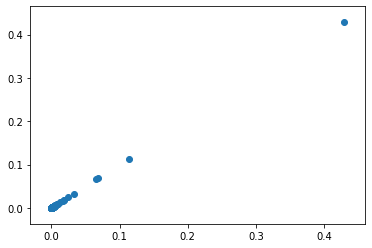

In [84]:
plt.scatter(connectivity_matrices_ntsr1.loc['VISp6a'], connectivity_matrices_rbp4.loc['VISp6a'])

In [ ]:
plt.scatter(ntsr1.loc['VISp6a'], rbp4.loc['VISp6a'])

In [76]:
#117,118,119,120,121
connectivity_matrices[2][4]

array([3.92816832e-05, 9.17874086e-04, 3.79996591e-03, 2.69283995e-04,
       2.24536081e-03, 4.40676465e-04, 7.77149565e-04, 2.04592651e-04,
       6.89922118e-04, 1.21745921e-04, 1.73668932e-03, 5.37151451e-04,
       1.64946884e-04, 3.58011447e-04, 4.00256544e-04, 4.86392164e-04,
       2.66332951e-04, 4.50797627e-03, 4.92806910e-03, 1.64357825e-02,
       4.28403025e-01, 9.74797654e-03, 1.28198777e-02, 3.08958108e-03,
       5.77037295e-03, 3.24030862e-03, 1.22062498e-03, 2.97605724e-04,
       3.96176829e-05, 1.27601980e-04, 2.34079603e-04, 4.73182297e-04,
       3.86771703e-04, 2.86920003e-04, 2.98403569e-04, 2.43974539e-02,
       1.87698372e-02, 3.78505036e-03, 8.43006305e-03, 8.92810061e-03,
       2.00083242e-03, 2.04904393e-04, 5.28815573e-04, 1.50242128e-03,
       1.24511248e-05, 1.54421057e-04, 5.99268455e-04, 2.38780699e-05,
       2.65486041e-03, 7.78747697e-05, 2.63482363e-04, 7.20785406e-04,
       4.70159429e-04, 3.33243034e-04, 3.32215007e-03, 1.01121704e-04,
      

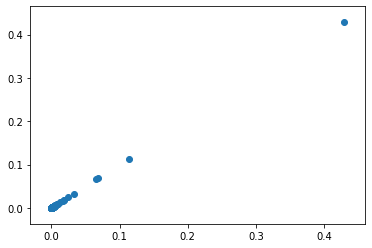

In [77]:
plt.scatter(connectivity_matrices[2][4], connectivity_matrices[3][4])

In [49]:
ia_map[ontological_order_leaves[121]]

'VISp6a'

In [32]:
connectivity_matrices[2]

array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [7.84144108e-05, 1.31288939e-03, 6.68723973e-03, ...,
        1.26371383e-05, 1.43194440e-05, 8.96462392e-06],
       [3.92816832e-05, 9.17874086e-04, 3.79996591e-03, ...,
        1.37961290e-06, 9.98857250e-07, 2.45807009e-07],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])

In [37]:
def fix_pdcsv(csv):
    
    #wt_conn = pd.read_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget.csv',  header=[0,1])
    csv_rownames = np.asarray(csv.iloc[:,0])
    csv = csv.iloc[:,1:]
    csv.index = csv_rownames
    return(csv)

In [42]:
ntsr1 = fix_pdcsv(pd.read_csv('/Users/samsonkoelle/ntsr1_leafsmooth_leafsurface_sumtarget_1201.csv', header= [0,1]))
rbp4 = fix_pdcsv(pd.read_csv('/Users/samsonkoelle/rbp4_leafsmooth_leafsurface_sumtarget_1201.csv', header= [0,1]))

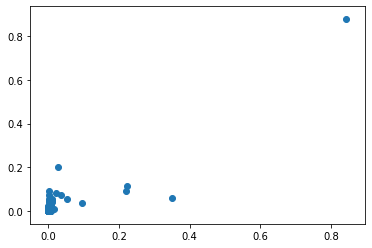

In [43]:
plt.scatter(ntsr1.loc['VISp6a'], rbp4.loc['VISp6a'])

In [24]:
#connectivity_data
surfaces = surfaces#_str
cres = crelist
structures_smooth = leafs
structures_surface = leafs
model_ordering_leafs = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
model_ordering_surfaces = np.asarray([ontological_order_leaves_majors,ontological_order_leaves]).transpose()
model_ordering_leafs = model_ordering_leafs#[117:123]
model_ordering_surfaces = model_ordering_summaries#[117:123]
eval_cres = eval_cres
source_ordering = ontological_order_leaves#[117:123]
target_ordering= ontological_order
connectivity_matrices = get_connectivity_matrices3(connectivity_data, surfaces, cres, structures_smooth,structures_surface, model_ordering_leafs, model_ordering_leafs, source_ordering, target_ordering, eval_cres)        

0 68.0
1 667.0
2 526157192.0
3 526157196.0
4 526322264.0
5 320.0
6 943.0
7 648.0
8 844.0
9 882.0
10 656.0
11 962.0
12 767.0
13 1021.0
14 1085.0
15 558.0
16 838.0
17 654.0
18 702.0
19 889.0
20 929.0
21 981.0
22 201.0
23 1047.0
24 1070.0
25 1038.0
26 1062.0
27 1030.0
28 113.0
29 1094.0
30 1128.0
31 478.0
32 510.0
33 878.0
34 657.0
35 950.0
36 974.0
37 1102.0
38 2.0
39 450.0
40 854.0
41 577.0
42 625.0
43 945.0
44 1026.0
45 1006.0
46 670.0
47 1086.0
48 1111.0
49 9.0
50 461.0
51 182305693.0
52 182305697.0
53 182305701.0
54 182305705.0
55 182305709.0
56 182305713.0
57 873.0
58 806.0
59 1035.0
60 1090.0
61 862.0
62 893.0
63 36.0
64 180.0
65 148.0
66 187.0
67 638.0
68 662.0
69 897.0
70 1106.0
71 1010.0
72 1058.0
73 857.0
74 849.0
75 527.0
76 600.0
77 678.0
78 252.0
79 156.0
80 243.0
81 735.0
82 251.0
83 816.0
84 847.0
85 954.0
86 1005.0
87 696.0
88 643.0
89 759.0
90 791.0
91 249.0
92 456.0
93 959.0
94 755.0
95 990.0
96 1023.0
97 520.0
98 598.0
99 1074.0
100 905.0
101 1114.0
102 233.0
103 601.0

247 814.0
248 961.0
249 260.0
250 268.0
251 1139.0
252 639.0
253 655.0
254 663.0
255 788.0
256 566.0
257 382.0
258 423.0
259 463.0
260 10703.0
261 10704.0
262 632.0
263 982.0
264 19.0
265 1121.0
266 20.0
267 52.0
268 139.0
269 28.0
270 526.0
271 543.0
272 664.0
273 727.0
274 743.0
275 843.0
276 1037.0
277 1084.0
278 502.0
279 583.0
280 952.0
281 966.0
282 131.0
283 303.0
284 311.0
285 451.0
286 327.0
287 334.0
288 780.0
289 672.0
290 56.0
291 998.0
292 754.0
293 250.0
294 258.0
295 266.0
296 310.0
297 333.0
298 23.0
299 292.0
300 544.0
301 551.0
302 559.0
303 1105.0
304 403.0
305 1022.0
306 1031.0
307 342.0
308 298.0
309 564.0
310 596.0
311 581.0
312 351.0
313 287.0
314 629.0
315 685.0
316 718.0
317 725.0
318 733.0
319 741.0
320 414.0
321 422.0
322 609.0
323 1044.0
324 1072.0
325 1079.0
326 1088.0
327 496345664.0
328 496345668.0
329 496345672.0
330 218.0
331 1020.0
332 1029.0
333 325.0
334 255.0
335 1096.0
336 1104.0
337 64.0
338 1120.0
339 1113.0
340 155.0
341 59.0
342 362.0
343 366.0

494 1048.0
495 372.0
496 83.0
497 136.0
498 106.0
499 203.0
500 955.0
501 963.0
502 307.0
503 1098.0
504 1107.0
505 852.0
506 859.0
507 970.0
508 978.0
509 177.0
510 169.0
511 1069.0
512 209.0
513 202.0
514 225.0
515 217.0
516 765.0
517 773.0
518 781.0
519 206.0
520 230.0
521 222.0
522 912.0
523 976.0
524 984.0
525 1091.0
526 936.0
527 944.0
528 951.0
529 957.0
530 968.0
531 1007.0
532 1056.0
533 1064.0
534 1025.0
535 1033.0
536 1041.0
537 1049.0
538 989.0
539 91.0
540 846.0
0 68.0
1 667.0
2 526157192.0
3 526157196.0
4 526322264.0
5 320.0
6 943.0
7 648.0
8 844.0
9 882.0
10 656.0
11 962.0
12 767.0
13 1021.0
14 1085.0
15 558.0
16 838.0
17 654.0
18 702.0
19 889.0
20 929.0
21 981.0
22 201.0
23 1047.0
24 1070.0
25 1038.0
26 1062.0
27 1030.0
28 113.0
29 1094.0
30 1128.0
31 478.0
32 510.0
33 878.0
34 657.0
35 950.0
36 974.0
37 1102.0
38 2.0
39 450.0
40 854.0
41 577.0
42 625.0
43 945.0
44 1026.0
45 1006.0
46 670.0
47 1086.0
48 1111.0
49 9.0
50 461.0
51 182305693.0
52 182305697.0
53 182305701.0

205 274.0
206 330.0
207 542.0
208 430.0
209 687.0
210 590.0
211 622.0
212 312782550.0
213 312782554.0
214 312782558.0
215 312782562.0
216 312782566.0
217 312782570.0
218 312782604.0
219 312782608.0
220 312782612.0
221 312782616.0
222 312782620.0
223 312782624.0
224 97.0
225 1127.0
226 234.0
227 289.0
228 729.0
229 786.0
230 540.0
231 888.0
232 692.0
233 335.0
234 368.0
235 836.0
236 427.0
237 988.0
238 977.0
239 1045.0
240 507.0
241 188.0
242 196.0
243 204.0
244 159.0
245 597.0
246 605.0
247 814.0
248 961.0
249 260.0
250 268.0
251 1139.0
252 639.0
253 655.0
254 663.0
255 788.0
256 566.0
257 382.0
258 423.0
259 463.0
260 10703.0
261 10704.0
262 632.0
263 982.0
264 19.0
265 1121.0
266 20.0
267 52.0
268 139.0
269 28.0
270 526.0
271 543.0
272 664.0
273 727.0
274 743.0
275 843.0
276 1037.0
277 1084.0
278 502.0
279 583.0
280 952.0
281 966.0
282 131.0
283 303.0
284 311.0
285 451.0
286 327.0
287 334.0
288 780.0
289 672.0
290 56.0
291 998.0
292 754.0
293 250.0
294 258.0
295 266.0
296 310.0
297 

In [29]:
#target_ordering= ontological_order_leaves

rnames = np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))])
ipsi_target_regions = connectivity_data.ipsi_target_regions
contra_target_regions = connectivity_data.contra_target_regions                               
ipsi_indices= np.asarray([])
contra_indices = np.asarray([])
for iy in target_ordering: 
    ipsi_indices = np.concatenate([ipsi_indices, np.where(ipsi_target_regions==iy)[0]] )
    contra_indices = np.concatenate([contra_indices, np.where(contra_target_regions==iy)[0]] )
ipsi_indices = np.asarray(ipsi_indices, dtype = int)   
contra_indices = np.asarray(contra_indices, dtype = int)    
reorder = np.concatenate([ipsi_indices, len(ipsi_indices) + contra_indices])  
ntarget = len(reorder)

colids = np.concatenate([ipsi_target_regions, contra_target_regions])[reorder]
cnames = np.asarray([ia_map[colids[i]] for i in range(len(colids))])


ccomb = np.vstack([np.concatenate([np.repeat('ipsi',291),np.repeat('contra',286)]), cnames])
ccomb = np.asarray(ccomb)
tuples2 = list(zip(*ccomb))
cnam_multi = pd.MultiIndex.from_tuples(tuples2, names=['first', 'second'])

In [30]:
rnames = np.asarray([ia_map[ontological_order_leaves[i]] for i in range(len(ontological_order_leaves))])

In [33]:
connectivity_matrices_wt_sumall = pd.DataFrame(connectivity_matrices[0], columns = cnam_multi, index=rnames)

In [35]:
connectivity_matrices_cux2_sumall = pd.DataFrame(connectivity_matrices[1], columns = cnam_multi, index=rnames)
connectivity_matrices_ntsr1_sumall = pd.DataFrame(connectivity_matrices[2], columns = cnam_multi, index=rnames)
connectivity_matrices_rbp4_sumall = pd.DataFrame(connectivity_matrices[3], columns = cnam_multi, index=rnames)
connectivity_matrices_tlx3_sumall = pd.DataFrame(connectivity_matrices[4], columns = cnam_multi, index=rnames)

In [34]:
connectivity_matrices_wt_sumall.to_csv('/Users/samsonkoelle/wt_leafsmooth_leafsurface_sumtarget_1201.csv')

In [32]:
crelist

['C57BL/6J',
 'Cux2-IRES-Cre',
 'Ntsr1-Cre_GN220',
 'Rbp4-Cre_KL100',
 'Tlx3-Cre_PL56']

In [36]:
connectivity_matrices_cux2_sumall.to_csv('/Users/samsonkoelle/cux2_leafsmooth_leafsurface_sumtarget_1201.csv')
connectivity_matrices_ntsr1_sumall.to_csv('/Users/samsonkoelle/ntsr1_leafsmooth_leafsurface_sumtarget_1201.csv')
connectivity_matrices_rbp4_sumall.to_csv('/Users/samsonkoelle/rbp4_leafsmooth_leafsurface_sumtarget_1201.csv')
connectivity_matrices_tlx3_sumall.to_csv('/Users/samsonkoelle/tlx3_leafsmooth_leafsurface_sumtarget_1201.csv')